# Setup

In [1]:
import json
import os
import sys
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import roc_curve, recall_score, balanced_accuracy_score

from pymer4.models import Lmer

from utils import read_csv_non_utf, true_skill_statistic, test_thresholds, ratios_to_DI_cats, get_zero_nonzero_datasets, preprocess_data
from model_utils import PymerModelWrapper, HurdleModelEstimator, k_fold_cross_val
from plotting_utils import plot_ratio_confusion_matrix

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ferreiro_arias2024 = config['indiv_data_paths']['ferreiro_arias2024']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
fer_ari_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, ferreiro_arias2024)

In [3]:
# Choosing the dataset - "mammals" or "birds"
dataset = 'mammals'

# Reading in the dataset
if dataset == 'birds':
    data = pd.read_csv(fer_ari_path)
elif dataset == 'mammals':
    data = read_csv_non_utf(ben_lop_path)

data.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


# Fitting the model using `pymer`

This is the same linear mixed-effects hurdle model as in Benitez-Lopez et al. (2019).

In [4]:
# The model specifications, taken from the supplementary of Benitez-Lopez (post-model selection) 
#  and the GitHub repo that Iago shared
if dataset == 'mammals':
    formula_zero = 'local_extirpation ~ BM + DistKm + I(DistKm^2) + PopDens + Stunting + Reserve + (1|Country) + (1|Species) + (1|Study)'
    formula_nonzero = 'RR ~ BM + DistKm + I(DistKm^2) + PopDens + I(PopDens^2) + BM*DistKm + (1|Country) + (1|Species) + (1|Study)'
elif dataset == 'birds':
    formula_zero = 'local_extirpation ~ Body_Mass + Dist_Hunters + TravDist + PopDens + Stunting + NPP + Reserve + Body_Mass*Dist_Hunters + Body_Mass*TravDist + Body_Mass*Stunting + NPP*Dist_Hunters + (1|Country) + (1|Species)'
    formula_nonzero = 'RR ~ Body_Mass + Dist_Hunters + TravDist + PopDens + Stunting + NPP + Reserve + Body_Mass*Dist_Hunters + Body_Mass*TravDist + Body_Mass*Stunting + NPP*Dist_Hunters + (1|Country) + (1|Species)'

In [5]:
# Establishing the two mixed-effects models and putting into a unified hurdle model
control_str = "optimizer='bobyqa', optCtrl=list(maxfun=1e5)"
use_rfx = True

zero_model = PymerModelWrapper(Lmer, formula = formula_zero, family = 'binomial', control_str = control_str, use_rfx = use_rfx)
nonzero_model = PymerModelWrapper(Lmer, formula = formula_nonzero, family = 'gaussian', use_rfx = use_rfx)

extirp_pos = False
outlier_cutoff = 15 if dataset == 'mammals' else 5
data_args = {'outlier_cutoff' : outlier_cutoff, 'dataset' : dataset}

hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, prob_thresh = 0.85, extirp_pos = extirp_pos,
                                    data_args = data_args)

In [6]:
# Preprocessing data and getting ground-truth ratios
pp_data = preprocess_data(data, include_indicators = False, include_categorical = True, standardize = True, 
                          log_trans_cont = True, dataset = dataset)
resp_col = 'ratio' if dataset == 'mammals' else 'RR'
ratio = pp_data[resp_col]

In [7]:
# A toy dataset to test performance when there are only new levels (mirrors generalization scenario)
pp_data_alt = pp_data.copy(deep = True)
pp_data_alt['Country'] = 'Transylvania'
pp_data_alt['Species'] = 'Gluteus maximus'
pp_data_alt['Study'] = 1693
pp_data_alt['Family'] = 'Somethinglatinae'

pp_data_alt.head()

,BM,DistKm,PopDens,Stunting,TravTime,LivestockBio,Literacy,Reserve,Country,Species,Study,Family,Order,Region,Diet,ratio
0,0.161001,-4.193614,-0.408315,-0.114746,0.341297,0.127855,0.033068,0,Transylvania,Gluteus maximus,1693,Somethinglatinae,Cetartiodactyla,Africa,Herb,0.377193
1,2.637685,-4.193614,-0.408315,-0.114746,0.341297,0.127855,0.033068,0,Transylvania,Gluteus maximus,1693,Somethinglatinae,Proboscidea,Africa,Herb,0.865690
2,0.161001,-2.594916,-0.408315,-0.114746,0.341297,0.127855,0.033068,0,Transylvania,Gluteus maximus,1693,Somethinglatinae,Cetartiodactyla,Africa,Herb,0.833333
3,2.637685,-2.594916,-0.408315,-0.114746,0.341297,0.127855,0.033068,0,Transylvania,Gluteus maximus,1693,Somethinglatinae,Proboscidea,Africa,Herb,0.900862
4,0.161001,-1.976455,-0.408315,-0.114746,0.341297,0.127855,0.033068,0,Transylvania,Gluteus maximus,1693,Somethinglatinae,Cetartiodactyla,Africa,Herb,0.956140


## Mixed effects hurdle model on the FULL dataset

The log likelihood is still lower on the binomial model than reported, but fitted coefficients seems to roughly match.

In [8]:
# Fitting the hurdle model
with warnings.catch_warnings(action = 'ignore'):
    hurdle_model.fit(pp_data)

In [9]:
# Getting the optimal threshold for the binomial model
y_pred_zero = hurdle_model.zero_model.predict_proba(pp_data)
y_pred_zero = y_pred_zero[ : , 1]
y_true_zero = (pp_data[resp_col] == 0).astype(int).values if extirp_pos else (pp_data[resp_col] != 0).astype(int).values

opt_thresh, metrics = test_thresholds(y_pred_zero, y_true_zero)
print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')

Best threshold was found to be 0.85 with a TSS of 0.734


In [10]:
# Making predictions with the full hurdle model
hurdle_model.prob_thresh = round(opt_thresh, 3)
y_pred = hurdle_model.predict(pp_data)

In [11]:
# Back-transforming to recover actual abundance ratios predicted by the hurdle model
pred_ratios = y_pred.copy()
pred_ratios[pred_ratios != 0] = np.exp(pred_ratios[pred_ratios != 0]) # don't need to back-transform predicted extirpations - not RRs!
pred_DI_cats = ratios_to_DI_cats(pred_ratios)
true_DI_cats = ratios_to_DI_cats(ratio)

In [12]:
# Key metrics - not directly comparable to theirs, b/c they use the cross-val versions...
balanced_acc = balanced_accuracy_score(true_DI_cats, pred_DI_cats)
pseudo_r2 = np.corrcoef(pred_ratios, ratio)[0, 1] ** 2

print(f'Full-dataset balanced accuracy: {round(balanced_acc * 100, 2)}%')
print(f'Full-dataset pseudo-R^2: {round(pseudo_r2, 3)}') # why is this off by a factor of 10?

Full-dataset balanced accuracy: 59.85%
Full-dataset pseudo-R^2: 0.031


### Matching Figures S5A, S5B, and S6C

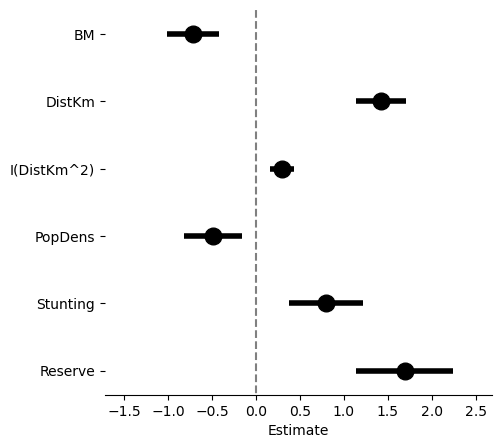

In [13]:
# Fixed effect coefficient estimates for the binomial model
hurdle_model.zero_model.model.plot_summary(plot_intercept = False, ranef_alpha = 0, figsize = (5, 5));

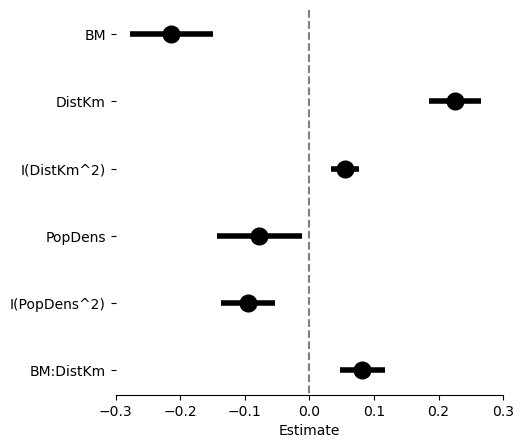

In [14]:
# Fixed effect coefficient estimates for the gaussian model
hurdle_model.nonzero_model.model.plot_summary(plot_intercept = False, ranef_alpha = 0, figsize = (5, 5));
plt.xlim((-0.3, 0.3));

In [16]:
hurdle_model.zero_model.model.coefs

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.273118,1.634145,2.912092,0.326013,9.709633,5.125072,18.395247,0.906626,0.836737,0.948441,6.972476,3.114099e-12,***
BM,-0.718224,-1.018101,-0.418346,0.153002,0.487618,0.361280,0.658134,0.327784,0.265397,0.396913,-4.694224,2.676213e-06,***
DistKm,1.423235,1.138896,1.707574,0.145074,4.150527,3.123320,5.515567,0.805845,0.757477,0.846521,9.810437,1.015277e-22,***
I(DistKm^2),0.294692,0.160868,0.428517,0.068279,1.342713,1.174530,1.534979,0.573145,0.540131,0.605519,4.316008,1.588766e-05,***
PopDens,-0.490869,-0.824544,-0.157195,0.170245,0.612094,0.438435,0.854538,0.379689,0.304800,0.460782,-2.883306,3.935250e-03,**
Stunting,0.798563,0.375688,1.221437,0.215756,2.222345,1.455993,3.392060,0.689667,0.592833,0.772316,3.701226,2.145599e-04,***
Reserve,1.690918,1.141581,2.240255,0.280279,5.424456,3.131714,9.395723,0.844345,0.757970,0.903807,6.032977,1.609665e-09,***


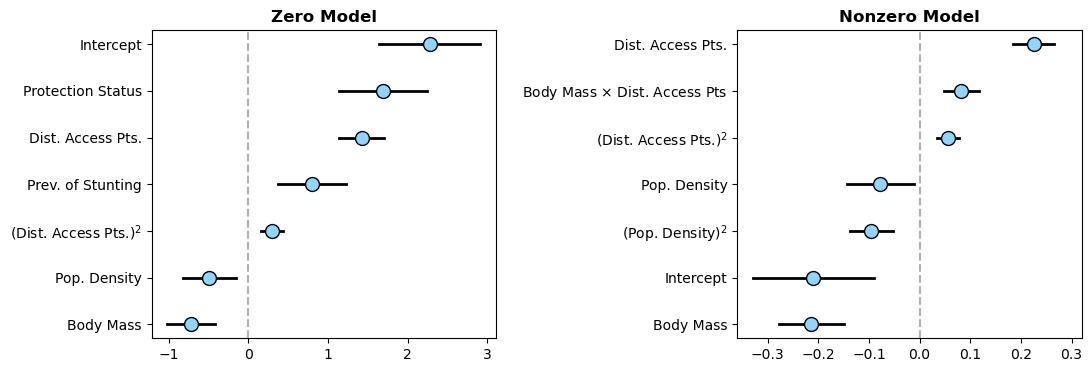

In [76]:
# Making a prettier plot of model coefficients
nonzero_coefs = hurdle_model.nonzero_model.model.coefs
nonzero_coefs['type'] = nonzero_coefs.index
nonzero_coefs = nonzero_coefs.sort_values('Estimate')

zero_coefs = hurdle_model.zero_model.model.coefs
zero_coefs['type'] = zero_coefs.index
zero_coefs = zero_coefs.sort_values('Estimate')

#  changing the names for plotting purposes
plot_names = {'DistKm' : 'Dist. Access Pts.',
              'BM:DistKm' : 'Body Mass $\\times$ Dist. Access Pts',
              'I(DistKm^2)' : '(Dist. Access Pts.)$^2$',
              'PopDens' : 'Pop. Density',
              'I(PopDens^2)' : '(Pop. Density)$^2$', 
              '(Intercept)' : 'Intercept',
              'BM' : 'Body Mass',
              'Stunting' : 'Prev. of Stunting',
              'Reserve' : 'Protection Status'}

#  plotting
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

for data, model, ax in zip([zero_coefs, nonzero_coefs], ['zero', 'nonzero'], axs):
    ax.scatter(data['Estimate'], data['type'].replace(plot_names), s = 100, edgecolor = 'black', 
               color = '#90d5ff', zorder = 100)
    for row in data.iterrows():
        row = row[1]
        name = plot_names[row['type']]
        ax.plot([row['2.5_ci'], row['97.5_ci']], [name, name], color = 'black', 
                linewidth = 2, zorder = 20)
    
    ax.axvline(0, linestyle = '--', color = 'grey', zorder = 0, alpha = 0.6)

    ax.set_title(f'{model} model'.title(), weight = 'bold')
    
axs[1].set_xlim((-0.36, 0.32))

fig.subplots_adjust(wspace = 0.7)

plt.savefig('../figures/linear_hurdle_coefficients.pdf', bbox_inches = 'tight')
plt.show()

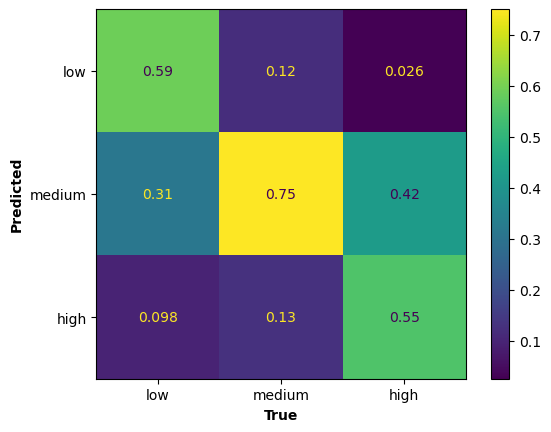

In [43]:
# Confusion matrix
fig, ax = plot_ratio_confusion_matrix(true_DI_cats, pred_DI_cats)

### Taking a look at the model summaries

In [44]:
# Binomial model
hurdle_model.zero_model.model.summary()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: local_extirpation~Body_Mass+Dist_Hunters+TravDist+PopDens+Stunting+NPP+Reserve+Body_Mass*Dist_Hunters+Body_Mass*TravDist+Body_Mass*Stunting+NPP*Dist_Hunters+(1|Country)+(1|Species)

Family: binomial	 Inference: parametric

Number of observations: 1444	 Groups: {'Species': 510.0, 'Country': 25.0}

Log-likelihood: -495.005 	 AIC: 1018.010

Random effects:

                Name    Var    Std
Species  (Intercept)  1.893  1.376
Country  (Intercept)  2.076  1.441

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.448,1.520,3.376,0.473,11.567,4.574,29.254,0.920,0.821,0.967,5.171,0.000,***
Body_Mass,0.012,-0.355,0.380,0.188,1.012,0.701,1.462,0.503,0.412,0.594,0.066,0.948,
Dist_Hunters,0.167,-0.217,0.551,0.196,1.181,0.805,1.734,0.542,0.446,0.634,0.851,0.395,
TravDist,0.490,0.100,0.879,0.199,1.632,1.105,2.409,0.620,0.525,0.707,2.464,0.014,*
PopDens,-0.910,-1.455,-0.364,0.278,0.403,0.233,0.695,0.287,0.189,0.410,-3.269,0.001,**
Stunting,0.174,-0.238,0.585,0.210,1.190,0.788,1.796,0.543,0.441,0.642,0.828,0.408,
NPP,-0.464,-0.856,-0.073,0.200,0.629,0.425,0.930,0.386,0.298,0.482,-2.324,0.020,*
Reserve,-0.311,-0.877,0.256,0.289,0.733,0.416,1.292,0.423,0.294,0.564,-1.075,0.283,
Body_Mass:Dist_Hunters,0.412,0.052,0.772,0.184,1.510,1.053,2.164,0.602,0.513,0.684,2.242,0.025,*
Body_Mass:TravDist,-0.306,-0.599,-0.013,0.149,0.736,0.549,0.987,0.424,0.355,0.497,-2.049,0.040,*


In [45]:
# Gaussian model
hurdle_model.nonzero_model.model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: RR~Body_Mass+Dist_Hunters+TravDist+PopDens+Stunting+NPP+Reserve+Body_Mass*Dist_Hunters+Body_Mass*TravDist+Body_Mass*Stunting+NPP*Dist_Hunters+(1|Country)+(1|Species)

Family: gaussian	 Inference: parametric

Number of observations: 1245	 Groups: {'Species': 472.0, 'Country': 25.0}

Log-likelihood: -1582.245 	 AIC: 3194.489

Random effects:

                 Name    Var    Std
Species   (Intercept)  0.185  0.430
Country   (Intercept)  0.077  0.277
Residual               0.579  0.761

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.243,-0.426,-0.059,0.093,12.298,-2.596,0.023,*
Body_Mass,-0.183,-0.265,-0.100,0.042,435.387,-4.329,0.000,***
Dist_Hunters,-0.079,-0.166,0.009,0.045,1205.906,-1.749,0.080,.
TravDist,0.064,-0.029,0.156,0.047,547.273,1.354,0.176,
PopDens,-0.078,-0.204,0.048,0.064,109.027,-1.220,0.225,
Stunting,-0.039,-0.142,0.064,0.052,116.767,-0.742,0.460,
NPP,0.068,-0.026,0.162,0.048,243.859,1.418,0.157,
Reserve,0.123,-0.017,0.263,0.072,365.804,1.721,0.086,.
Body_Mass:Dist_Hunters,0.073,-0.013,0.158,0.043,1169.277,1.668,0.096,.
Body_Mass:TravDist,-0.080,-0.157,-0.004,0.039,894.857,-2.054,0.040,*


## Mixed-effects hurdle model with cross-validation

This is just a naive random cross-validation, which is what they do in Benitez-Lopez et al. (2019) but not in Iago's new paper.

In [78]:
# 5-fold cross-validation using the mixed-effects hurdle model
num_folds = 5
class_metrics = ['balanced_accuracy', 'sensitivity', 'specificity']
classes = {0 : 'low', 1 : 'medium', 2 : 'high'}
reg_metrics = ['pseudo_r2']

metrics_dict = k_fold_cross_val(hurdle_model, pp_data, num_folds = num_folds, 
                                class_metrics = class_metrics, reg_metrics = reg_metrics, 
                                dataset = dataset)

Fold 0:
  training model
  getting test metrics
Fold 1:
  training model
  getting test metrics
Fold 2:
  training model
  getting test metrics
Fold 3:
  training model
  getting test metrics
Fold 4:
  training model
  getting test metrics


In [108]:
# A bit of cleaning up on the metrics data structure to make it ready for plotting
metrics_dict = {m : metrics_dict[m] for m in class_metrics} # tossing pseudo-r2 for now

metrics = pd.DataFrame(metrics_dict)
metrics = pd.concat([metrics[m].explode() for m in class_metrics], axis = 1).reset_index()
metrics = metrics.rename(columns = {'index' : 'DI_category'})
metrics = metrics.melt(id_vars = ['DI_category'], value_vars = class_metrics, var_name = 'metric')

metric_names = {'balanced_accuracy' : 'Balanced Accuracy',
                'sensitivity' : 'Sensitivity', 
                'specificity' : 'Specificity'}
metrics['metric'] = metrics['metric'].replace(metric_names)

metrics.head()

,DI_category,metric,value
0,low,Balanced Accuracy,0.65119
1,low,Balanced Accuracy,0.639982
2,low,Balanced Accuracy,0.676303
3,low,Balanced Accuracy,0.641222
4,low,Balanced Accuracy,0.664325


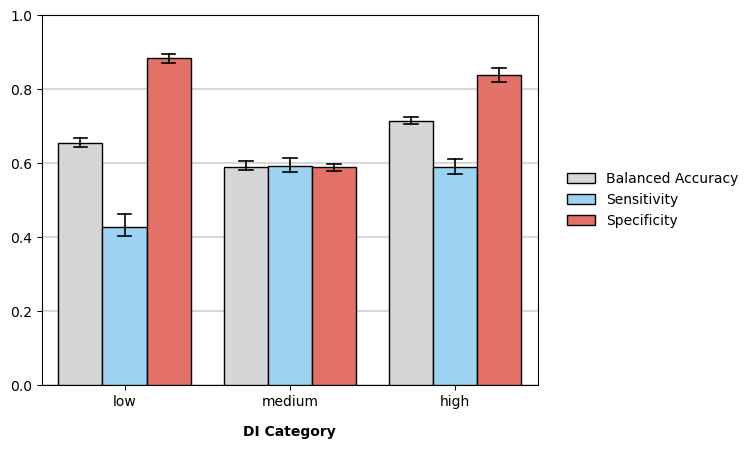

In [111]:
# Plotting with error bars to account for variation between splits in the 5-fold cross-validation
ax = sns.barplot(metrics, x = 'DI_category', y = 'value', hue = 'metric', edgecolor = 'black',
                 palette = ['#d6d6d6', '#90d5ff', '#f75f54'], capsize = 0.25, err_kws = {'color': 'black', 'linewidth': 1.2, 'zorder' : 100},
                 zorder = 50)

plt.ylabel('')
plt.xlabel('DI Category', weight = 'bold', labelpad = 12)

ax.get_legend().set_title(None)
ax.legend(loc = 'center right', bbox_to_anchor = (1.43, 0.5), frameon = False)

ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5, alpha = 0.3)

plt.ylim((0, 1))

plt.savefig('../figures/linear_hurdle_cross_val_DI_cats.pdf', bbox_inches = 'tight')
plt.show()

# Auxiliary experiment: looking at only the binomial model

This is a reproduction of Gallego-Zamorano et al. (2020), which only uses the local extirpation component of the hurdle model.

## Reading in the data

This is both the Gallego-Zamorano _et al._ (2020) and Benitez-Lopez _et al._ (2019) versions--I modified the latter to recover the former!

Remember that the response variable here is coded as `local_extirpation=0`.

In [4]:
# Read in the alternate dataset - this should be the same as Benitez-Lopez et al. (2019)!
alt_dataset_fp = '/Users/emiliolr/Desktop/LIFE/benitez_lopez/huntingdb.csv' 
alt_data = read_csv_non_utf(alt_dataset_fp)
alt_data = alt_data.rename(columns = {'PopDensUpd' : 'PopDens'})

alt_data.head()

,Reference,dataset2,Species,BM,DistKm,PopDens,Country,Binomial
0,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.823909,-0.017729,Gabon,1
1,"Laurance et al., 2006",1,Loxodonta africana,3.595500,-0.823909,-0.017729,Gabon,1
2,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.397940,-0.017729,Gabon,1
3,"Laurance et al., 2006",1,Loxodonta africana,3.595500,-0.397940,-0.017729,Gabon,1
4,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.154902,-0.017729,Gabon,1


In [5]:
# Trying to recover the alternate dataset from the original Benitez-Lopez dataset... should be the same!
cols_to_keep = ['Reference', 'Study', 'Species', 'BM', 'DistKm', 'PopDens', 'Country', 'ratio']

#  extract the needed variables
ben_lop2019_sub = ben_lop2019[cols_to_keep].copy(deep = True)
ben_lop2019_sub['Binomial'] = (ben_lop2019_sub['ratio'] > 0).astype(int)
ben_lop2019_sub = ben_lop2019_sub.drop(columns = ['ratio'])

#  rename study column
ben_lop2019_sub = ben_lop2019_sub.rename(columns = {'Study' : 'dataset2'})

#  log10 transform continuous predictors
ben_lop2019_sub.loc[ben_lop2019_sub['PopDens'] == 0, 'PopDens'] = 0.1

cont_pred = ['BM', 'DistKm', 'PopDens']
for pred in cont_pred:
    ben_lop2019_sub[pred] = np.log10(ben_lop2019_sub[pred])

ben_lop2019_sub.head()

,Reference,dataset2,Species,BM,DistKm,PopDens,Country,Binomial
0,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-1.301030,-0.065502,Gabon,1
1,"Laurance et al., 2006",1,Loxodonta africana,3.595500,-1.301030,-0.065502,Gabon,1
2,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.522879,-0.065502,Gabon,1
3,"Laurance et al., 2006",1,Loxodonta africana,3.595500,-0.522879,-0.065502,Gabon,1
4,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.221849,-0.065502,Gabon,1


In [6]:
# Checking the level of agreement between the two pre-processed datasets
ben_lop2019_sub = ben_lop2019_sub.sort_values(by = ['Reference', 'Species'])
alt_data = alt_data.sort_values(by = ['Reference', 'Species'])

#  looking at response variable
num_disagree = (alt_data['Binomial'] != ben_lop2019_sub['Binomial']).sum()
print(f'Response variable disagreement count: {num_disagree}')
print()

#  looking at continuos predictors
for pred in cont_pred:
    mae = np.mean(np.abs(alt_data[pred] - ben_lop2019_sub[pred]))
    print(f'MAE between datasets for {pred}: {round(mae, 3)}')
print()

#  looking at categorical predictors
cat_pred = ['Species', 'Reference', 'Country']
for pred in cat_pred:
    num_disagree = (alt_data[pred] != ben_lop2019_sub[pred]).sum()
    print(f'{pred} disagreement count: {num_disagree}')

Response variable disagreement count: 0

MAE between datasets for BM: 0.0
MAE between datasets for DistKm: 0.016
MAE between datasets for PopDens: 0.059

Species disagreement count: 0
Reference disagreement count: 0
Country disagreement count: 0


## Specifying, fitting, and predicting with the mixed effects model

In [7]:
# Choosing dataset to use
dataset = alt_data

In [8]:
# Specifying the mixed effects model and fitting to the data using pymer4 
binomial_formula = 'Binomial ~ BM + DistKm + I(DistKm^2) + PopDens + (1|Country) + (1|Species) + (1|dataset2)'

bin_model = Lmer(binomial_formula, data = dataset, family = 'binomial')
bin_model.fit(REML = True)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: Binomial~BM+DistKm+I(DistKm^2)+PopDens+(1|Country)+(1|Species)+(1|dataset2)

Family: binomial	 Inference: parametric

Number of observations: 3281	 Groups: {'Species': 296.0, 'dataset2': 163.0, 'Country': 37.0}

Log-likelihood: -977.528 	 AIC: 1971.055

Random effects:

                 Name    Var    Std
Species   (Intercept)  1.292  1.137
dataset2  (Intercept)  2.359  1.536
Country   (Intercept)  0.574  0.758

No random effect correlations specified

Fixed effects:



/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.563,1.778,3.347,0.400,12.973,5.921,28.426,0.928,0.856,0.966,6.404,0.000,***
BM,-0.669,-0.966,-0.371,0.152,0.512,0.381,0.690,0.339,0.276,0.408,-4.406,0.000,***
DistKm,0.732,-0.126,1.590,0.438,2.079,0.882,4.903,0.675,0.469,0.831,1.673,0.094,.
I(DistKm^2),1.897,1.193,2.601,0.359,6.666,3.297,13.479,0.870,0.767,0.931,5.281,0.000,***
PopDens,-0.578,-1.051,-0.104,0.242,0.561,0.349,0.901,0.359,0.259,0.474,-2.390,0.017,*


In [9]:
# Making predictions with the model and caluculating the optimal threshold
y_pred = bin_model.predict(dataset, use_rfx = True, skip_data_checks = True, verify_predictions = False)
y_pred = np.asarray(y_pred)
y_true = dataset['Binomial']

opt_thresh, metrics = test_thresholds(y_pred, y_true)
print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')
metrics

Best threshold was found to be 0.85 with a TSS of 0.713


,threshold,TSS,sensitivity,specificity
0,0.00,0.000000,1.000000,0.000000
1,0.05,0.000000,1.000000,0.000000
2,0.10,0.000000,1.000000,0.000000
3,0.15,0.019608,1.000000,0.019608
4,0.20,0.044118,1.000000,0.044118
5,0.25,0.080882,1.000000,0.080882
6,0.30,0.114152,0.998956,0.115196
7,0.35,0.168088,0.996519,0.171569
8,0.40,0.221313,0.995823,0.225490
9,0.45,0.285401,0.993735,0.291667


In [10]:
# The maximum sensitivity value is slightly different, but my guess is they ignored the places where
#  sensitivity=1.0... if you look where sensitivity is first <1.0, you get their reported value for TSS!
max_sens = metrics['TSS'].iloc[np.argmax(metrics['sensitivity'])]
max_spec = metrics['TSS'].iloc[np.argmax(metrics['specificity'])]

print(f"TSS when choosing the threshold to maximize sensitivity: {round(max_sens, 3)}")
print(f"TSS when choosing the threshold to maximize specificity: {round(max_spec, 3)}")

TSS when choosing the threshold to maximize sensitivity: 0.0
TSS when choosing the threshold to maximize specificity: 0.546
